У нас есть данные АА-теста с '2022-12-25' по '2022-12-31'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.


In [11]:
import pandas as pd
import pandahouse as ph
import random
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#подключаюсь к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
# выгружаю данные по группам за необходимый период
query = """
    SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2022-12-25' and '2022-12-31'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [4]:
# проверка что наша система корректно бьет пользователей на группы, то есть размеры групп примерно одинаковые
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


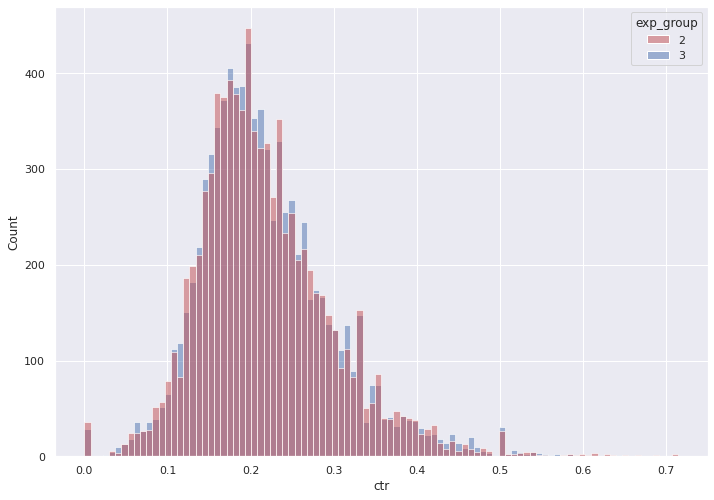

In [5]:
# график распределения
#визуально распределение двух групп похоже
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [6]:
#10000 АА-тестов
#количество юзеров в подвыборке - 500

#Пустой массив для p-values
p_values = []

for i in range(10000):
    #генерация случайных подвыборок без повторения
    sample2 = random.sample(df.query('exp_group == 2').ctr.to_list(), 500)
    sample3 = random.sample(df.query('exp_group == 3').ctr.to_list(), 500)

    #Т-тест
    t_test_result = ttest_ind(sample2, sample3)

    #значение p-value в виде массива
    p_values.append(t_test_result.pvalue)

p_values = np.array(p_values)

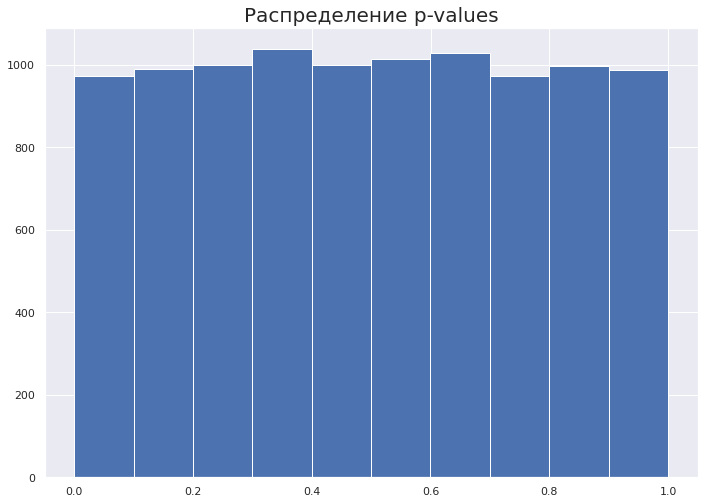

In [12]:
# распределение p-values выглядит равномерно. существенных стат различий между двумя группами нет
plt.hist(p_values)
plt.title('Распределение p-values', fontsize=20)
plt.show()

In [13]:
p_values

array([0.22337381, 0.61965938, 0.529155  , ..., 0.57387561, 0.43073604,
       0.92977238])

In [15]:
print('Провент p values, которые <= 5% составляет', len(p_values[p_values <= 0.05]) / len(p_values) * 100, '%')
print('Исходя из этого можем допустить, что система сплитования работает корректно, а допущение что различие CTR 2 и3 групп может быть статистически значимым, не превышает 5%.')

Провент p values, которые <= 5% составляет 4.4799999999999995 %
Исходя из этого можем допустить, что система сплитования работает корректно, а допущение что различие CTR 2 и3 групп может быть статистически значимым, не превышает 5%.
